# Character Extraction and Normalization

This notebook extracts individual characters from CAPTCHA images based on YOLO format bounding box annotations and normalizes them to a uniform size.

## Workflow:
1. Read YOLO format label files from `Segmented_dataset/train_labels/`
2. Extract character labels from filenames (e.g., `0a1gfi-0.txt` to `['0','a','1','g','f','i']`)
3. Crop character regions from original CAPTCHA images
4. Resize all characters to 32x32 RGB
5. Save to category folders (36 folders: 0-9, a-z)
6. Naming format: `{label}_{counter}_{original_filename}.png`

## Output:
- `Segmented_dataset/train_characters/{0-9,a-z}/` - 36 folders containing normalized character images

## 1. Import Required Libraries

In [3]:
import os
import cv2
import numpy as np
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

## 2. Configuration and Path Setup

In [5]:
# Define paths
PROJECT_ROOT = Path('..')
TRAIN_IMAGES_DIR = PROJECT_ROOT / 'dataset' / 'train'
TRAIN_LABELS_DIR = PROJECT_ROOT / 'Segmented_dataset' / 'train_labels'
OUTPUT_DIR = PROJECT_ROOT / 'Segmented_dataset' / 'train_characters'

# Normalization parameters
TARGET_SIZE = (32, 32)  # Width x Height
KEEP_RGB = True  # Keep color channels (not grayscale)

# Define 36 character classes (0-9, a-z)
CHARACTERS = [str(i) for i in range(10)] + [chr(i) for i in range(ord('a'), ord('z') + 1)]

print(f"Train Images: {TRAIN_IMAGES_DIR}")
print(f"Train Labels: {TRAIN_LABELS_DIR}")
print(f"Output Directory: {OUTPUT_DIR}")
print(f"Target Size: {TARGET_SIZE}")
print(f"Character Classes ({len(CHARACTERS)}): {CHARACTERS}")

Train Images: ..\dataset\train
Train Labels: ..\Segmented_dataset\train_labels
Output Directory: ..\Segmented_dataset\train_characters
Target Size: (32, 32)
Character Classes (36): ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## 3. Create Category Folders

In [6]:
# Create 36 category folders
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

for char in CHARACTERS:
    char_dir = OUTPUT_DIR / char
    char_dir.mkdir(exist_ok=True)

print(f"Created {len(CHARACTERS)} category folders in {OUTPUT_DIR}")
print(f"   Example folders: {', '.join([str(OUTPUT_DIR / c) for c in CHARACTERS[:5]])}...")

Created 36 category folders in ..\Segmented_dataset\train_characters
   Example folders: ..\Segmented_dataset\train_characters\0, ..\Segmented_dataset\train_characters\1, ..\Segmented_dataset\train_characters\2, ..\Segmented_dataset\train_characters\3, ..\Segmented_dataset\train_characters\4...


## 4. Helper Functions

In [7]:
def parse_filename_to_labels(filename):
    """
    Extract character labels from filename.
    Example: '0a1gfi-0.txt' to ['0', 'a', '1', 'g', 'f', 'i']
    """
    # Remove extension
    base_name = filename.replace('.txt', '').replace('.png', '')
    
    # Remove trailing suffix like '-0'
    if '-' in base_name:
        base_name = base_name.split('-')[0]
    
    # Convert to lowercase and split into characters
    labels = list(base_name.lower())
    
    return labels


def read_yolo_labels(label_path):
    """
    Read YOLO format labels from file.
    Format: <class_id> <x_center> <y_center> <width> <height> (normalized)
    Returns: List of [class_id, x_center, y_center, width, height]
    """
    boxes = []
    with open(label_path, 'r') as f:
        for line in f:
            values = line.strip().split()
            if len(values) == 5:
                class_id = int(values[0])
                x_center = float(values[1])
                y_center = float(values[2])
                width = float(values[3])
                height = float(values[4])
                boxes.append([class_id, x_center, y_center, width, height])
    return boxes


def yolo_to_bbox(x_center, y_center, width, height, img_width, img_height):
    """
    Convert YOLO normalized coordinates to pixel bounding box.
    Returns: (x_min, y_min, x_max, y_max) in pixels
    """
    x_min = int((x_center - width / 2) * img_width)
    y_min = int((y_center - height / 2) * img_height)
    x_max = int((x_center + width / 2) * img_width)
    y_max = int((y_center + height / 2) * img_height)
    
    # Ensure bounds are within image
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(img_width, x_max)
    y_max = min(img_height, y_max)
    
    return x_min, y_min, x_max, y_max


def resize_with_padding(image, target_size, keep_rgb=True):
    """
    Resize image to target size while maintaining aspect ratio.
    Adds padding if necessary.
    """
    target_w, target_h = target_size
    h, w = image.shape[:2]
    
    # Calculate scaling factor
    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    
    # Resize image
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # Create padded image
    if keep_rgb and len(image.shape) == 3:
        padded = np.ones((target_h, target_w, 3), dtype=np.uint8) * 255
    else:
        padded = np.ones((target_h, target_w), dtype=np.uint8) * 255
    
    # Calculate padding offsets (center the image)
    y_offset = (target_h - new_h) // 2
    x_offset = (target_w - new_w) // 2
    
    # Place resized image in center
    padded[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized
    
    return padded


print("Helper functions defined:")
print("   - parse_filename_to_labels()")
print("   - read_yolo_labels()")
print("   - yolo_to_bbox()")
print("   - resize_with_padding()")

# Test the filename parser
test_filename = '0a1gfi-0.txt'
test_labels = parse_filename_to_labels(test_filename)
print(f"\nTest: '{test_filename}' -> {test_labels}")

Helper functions defined:
   - parse_filename_to_labels()
   - read_yolo_labels()
   - yolo_to_bbox()
   - resize_with_padding()

Test: '0a1gfi-0.txt' -> ['0', 'a', '1', 'g', 'f', 'i']


## 5. Main Processing Loop

In [8]:
# Initialize counters for each character class
character_counters = {char: 0 for char in CHARACTERS}
total_extracted = 0
errors = []

# Get all label files
label_files = sorted(list(TRAIN_LABELS_DIR.glob('*.txt')))

print(f"Found {len(label_files)} label files to process\n")
print("Starting character extraction...\n")

# Process each label file
for label_file in tqdm(label_files, desc="Extracting characters"):
    try:
        # Get corresponding image file (.png only)
        img_name = label_file.stem + '.png'
        img_path = TRAIN_IMAGES_DIR / img_name
        
        if not img_path.exists():
            errors.append(f"Image not found: {img_path}")
            continue
        
        # Read image
        img = cv2.imread(str(img_path))
        if img is None:
            errors.append(f"Failed to read image: {img_path}")
            continue
        
        img_height, img_width = img.shape[:2]
        
        # Parse character labels from filename
        char_labels = parse_filename_to_labels(label_file.name)
        
        # Read bounding boxes
        boxes = read_yolo_labels(label_file)
        
        # Check if number of boxes matches number of characters
        if len(boxes) != len(char_labels):
            errors.append(f"Mismatch: {label_file.name} has {len(boxes)} boxes but {len(char_labels)} chars")
            continue
        
        # Process each character
        for i, (box, label) in enumerate(zip(boxes, char_labels)):
            # Convert YOLO coordinates to bounding box
            _, x_center, y_center, width, height = box
            x_min, y_min, x_max, y_max = yolo_to_bbox(
                x_center, y_center, width, height, img_width, img_height
            )
            
            # Crop character region
            char_img = img[y_min:y_max, x_min:x_max]
            
            # Skip if crop is invalid
            if char_img.size == 0:
                errors.append(f"Invalid crop for {label_file.name}, char {i}")
                continue
            
            # Resize to target size with padding
            normalized_img = resize_with_padding(char_img, TARGET_SIZE, KEEP_RGB)
            
            # Generate output filename
            character_counters[label] += 1
            counter = character_counters[label]
            output_filename = f"{label}_{counter:04d}_{label_file.stem}.png"
            output_path = OUTPUT_DIR / label / output_filename
            
            # Save normalized character image
            cv2.imwrite(str(output_path), normalized_img)
            total_extracted += 1
    
    except Exception as e:
        errors.append(f"Error processing {label_file.name}: {str(e)}")

print(f"\nExtraction complete!")
print(f"Total characters extracted: {total_extracted}")
print(f"Errors encountered: {len(errors)}")

Found 7764 label files to process

Starting character extraction...



Extracting characters: 100%|██████████| 7764/7764 [00:21<00:00, 358.96it/s]


Extraction complete!
Total characters extracted: 46244
Errors encountered: 34


## 6. Display Statistics

In [9]:
# Print character distribution
print("\n" + "="*60)
print("CHARACTER DISTRIBUTION")
print("="*60)

# Sort by character
sorted_counts = sorted(character_counters.items(), key=lambda x: x[0])

# Print in columns
print("\nDigits (0-9):")
for char, count in sorted_counts[:10]:
    print(f"  {char}: {count:5d} samples")

print("\nLetters (a-z):")
for i in range(0, 26, 5):
    line = "  "
    for char, count in sorted_counts[10+i:10+i+5]:
        line += f"{char}: {count:4d}  "
    print(line)

# Calculate statistics
counts = [count for char, count in character_counters.items()]
print(f"\nStatistics:")
print(f"   Total classes: {len(CHARACTERS)}")
print(f"   Total samples: {sum(counts)}")
print(f"   Average per class: {np.mean(counts):.1f}")
print(f"   Min samples: {min(counts)} (class: {min(character_counters.items(), key=lambda x: x[1])[0]})")
print(f"   Max samples: {max(counts)} (class: {max(character_counters.items(), key=lambda x: x[1])[0]})")
print(f"   Std deviation: {np.std(counts):.1f}")


CHARACTER DISTRIBUTION

Digits (0-9):
  0:  1293 samples
  1:  1315 samples
  2:  1221 samples
  3:  1303 samples
  4:  1286 samples
  5:  1247 samples
  6:  1281 samples
  7:  1236 samples
  8:  1250 samples
  9:  1273 samples

Letters (a-z):
  a: 1269  b: 1314  c: 1280  d: 1318  e: 1313  
  f: 1300  g: 1312  h: 1312  i: 1310  j: 1233  
  k: 1292  l: 1278  m: 1283  n: 1343  o: 1282  
  p: 1310  q: 1337  r: 1273  s: 1263  t: 1284  
  u: 1257  v: 1279  w: 1266  x: 1322  y: 1237  
  z: 1272  

Statistics:
   Total classes: 36
   Total samples: 46244
   Average per class: 1284.6
   Min samples: 1221 (class: 2)
   Max samples: 1343 (class: n)
   Std deviation: 29.4


## 7. Visualize Class Distribution

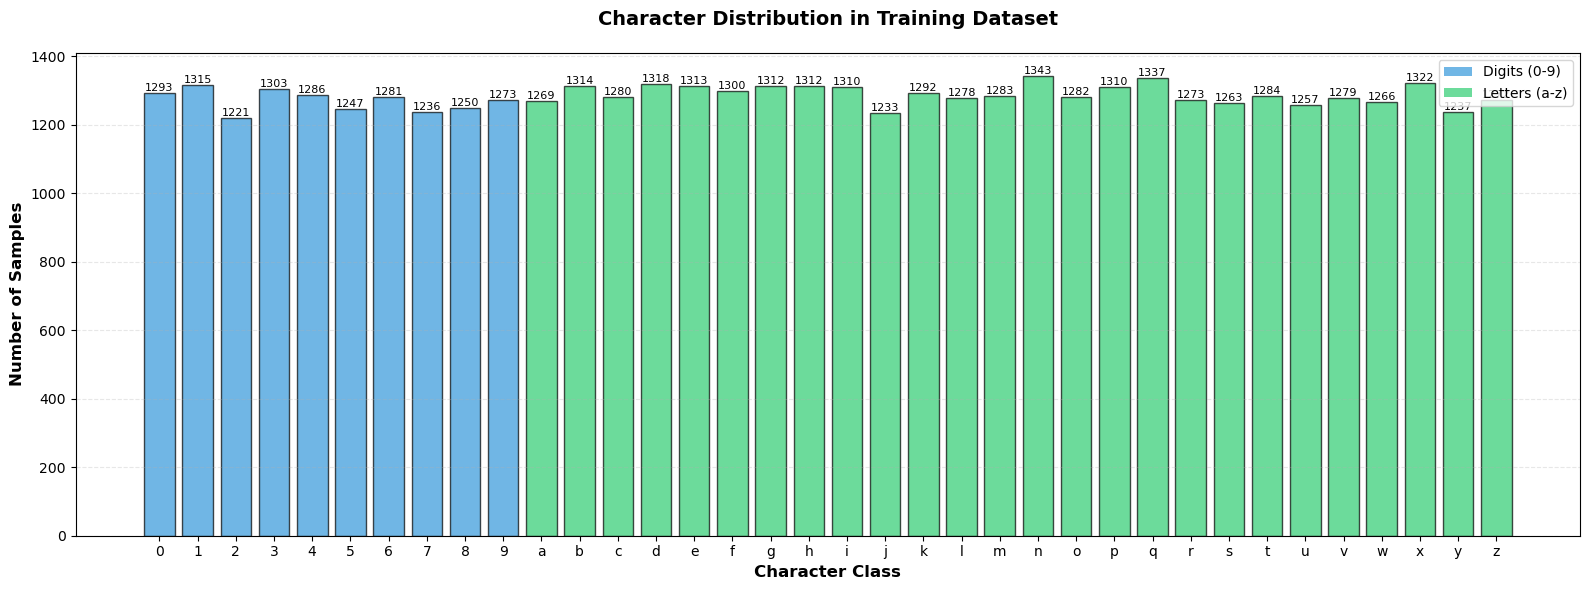


Bar chart displayed above


In [10]:
# Create bar chart
fig, ax = plt.subplots(figsize=(16, 6))

chars = [c[0] for c in sorted_counts]
counts = [c[1] for c in sorted_counts]

# Color digits differently from letters
colors = ['#3498db'] * 10 + ['#2ecc71'] * 26

bars = ax.bar(chars, counts, color=colors, alpha=0.7, edgecolor='black')

# Add count labels on top of bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count)}',
            ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Character Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax.set_title('Character Distribution in Training Dataset', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3498db', alpha=0.7, label='Digits (0-9)'),
    Patch(facecolor='#2ecc71', alpha=0.7, label='Letters (a-z)')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print("\nBar chart displayed above")

## 8. Display Sample Characters

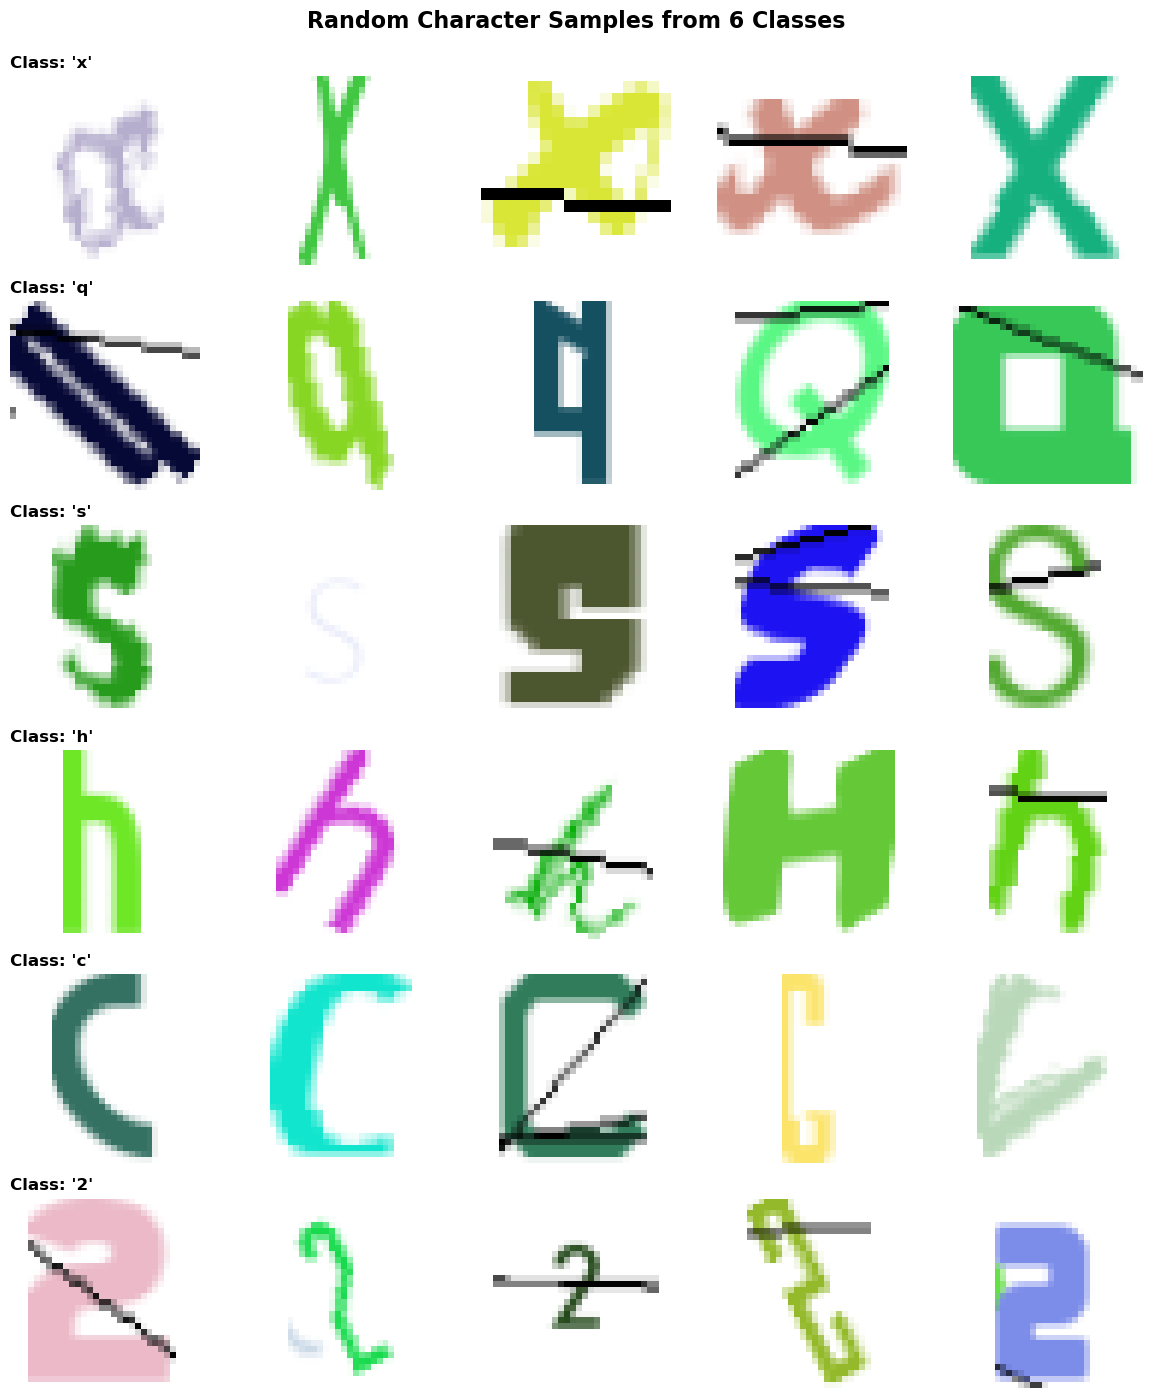


Sample characters displayed above


In [11]:
# Display 5 random samples from each of 6 random classes
import random

# Select 6 random classes that have samples
available_classes = [c for c, count in character_counters.items() if count > 0]
sample_classes = random.sample(available_classes, min(6, len(available_classes)))

fig, axes = plt.subplots(6, 5, figsize=(12, 14))
fig.suptitle('Random Character Samples from 6 Classes', fontsize=16, fontweight='bold', y=0.995)

for row, char_class in enumerate(sample_classes):
    char_dir = OUTPUT_DIR / char_class
    all_images = list(char_dir.glob('*.png'))
    
    # Select up to 5 random samples
    sample_images = random.sample(all_images, min(5, len(all_images)))
    
    for col, img_path in enumerate(sample_images):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        
        if col == 0:
            axes[row, col].set_title(f"Class: '{char_class}'", 
                                     fontsize=12, fontweight='bold', loc='left')

plt.tight_layout()
plt.show()

print("\nSample characters displayed above")

## 9. Error Report

In [12]:
if errors:
    print("\n" + "="*60)
    print("ERROR REPORT")
    print("="*60)
    print(f"\nTotal errors: {len(errors)}\n")
    
    # Display first 20 errors
    for i, error in enumerate(errors[:20]):
        print(f"{i+1}. {error}")
    
    if len(errors) > 20:
        print(f"\n... and {len(errors) - 20} more errors")
else:
    print("\nNo errors encountered during extraction!")


ERROR REPORT

Total errors: 34

1. Mismatch: 06yx8nkv-0.txt has 7 boxes but 8 chars
2. Mismatch: 0dw9b7hd-0.txt has 7 boxes but 8 chars
3. Mismatch: 2qugryl-0.txt has 6 boxes but 7 chars
4. Mismatch: 3l7brc-0.txt has 4 boxes but 6 chars
5. Mismatch: 5ie69wtf-0.txt has 7 boxes but 8 chars
6. Mismatch: 6ocl0d1-0.txt has 6 boxes but 7 chars
7. Mismatch: 7rl3w0-0.txt has 5 boxes but 6 chars
8. Mismatch: 9edktm-0.txt has 5 boxes but 6 chars
9. Mismatch: 9otpv3f-0.txt has 5 boxes but 7 chars
10. Mismatch: aqdlgv9-0.txt has 6 boxes but 7 chars
11. Mismatch: ct9ucv-0.txt has 1 boxes but 6 chars
12. Mismatch: cur2rqt-0.txt has 6 boxes but 7 chars
13. Mismatch: cxl8dhh6-0.txt has 9 boxes but 8 chars
14. Mismatch: eggxt3ug-0.txt has 7 boxes but 8 chars
15. Mismatch: hhk7sx-0.txt has 5 boxes but 6 chars
16. Mismatch: i97t1l11-0.txt has 7 boxes but 8 chars
17. Mismatch: ji9zjl3b-0.txt has 7 boxes but 8 chars
18. Mismatch: jzvf1-0.txt has 4 boxes but 5 chars
19. Mismatch: l2c07-0.txt has 1 boxes bu

## 10. Summary

In [13]:
print("\n" + "="*60)
print("EXTRACTION SUMMARY")
print("="*60)
print(f"\nCharacter extraction and normalization complete!")
print(f"\nResults:")
print(f"   - Total characters extracted: {total_extracted}")
print(f"   - Number of classes: {len(CHARACTERS)}")
print(f"   - Image size: {TARGET_SIZE[0]}x{TARGET_SIZE[1]} RGB")
print(f"   - Output directory: {OUTPUT_DIR}")
print(f"\nData ready for next step: Template Construction")
print(f"\nNext notebook: template_construction.ipynb")
print("="*60)


EXTRACTION SUMMARY

Character extraction and normalization complete!

Results:
   - Total characters extracted: 46244
   - Number of classes: 36
   - Image size: 32x32 RGB
   - Output directory: ..\Segmented_dataset\train_characters

Data ready for next step: Template Construction

Next notebook: template_construction.ipynb
